In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
CosCen = Slist['CosCen'][()]
CosVel = Slist['CosVel'][()]
#LzL = Slist['LZ_L'][()]
Satellites.size

19

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    templist = []
    templist2 = []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
            IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            val2 = tempFromMass(Mass, Abund, IE, ne1)
            templist2.extend(list(val2))
            # and the metallicity
            AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
            val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
            templist.extend(list(val))
            #zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            #templist.extend([zz]*tempIds.size)
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    templist = np.array(templist)
    templist2 = np.array(templist2)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    templist = templist[Idunique]
    templist2 = templist2[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    templist_, Idlist_ = templist[iidex_], Idlist[iidex_]
    templist2_ = templist2[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    temporder = np.zeros(IndexT_.size)
    temporder[is1] = templist_[is2]
    
    temporder2 = np.zeros(IndexT_.size)
    temporder2[is1] = templist2_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    temporder_near = temporder[icut]
    temporder_near2 = temporder2[icut]
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # WARNING, dangerous replacement
#     temporder_near = sim['SnapNumber_128/PartType0/StarFormationRate'][IndexT_near]
    #END WARNING
    
#     IE0 = sim['SnapNumber_128/PartType0/InternalEnergy'][IndexT_near]
#     ne10 = sim['SnapNumber_128/PartType0/ElectronAbundance'][IndexT_near]
#     t0 = tempFromMass(GasMasses, GassAbundances, IE0, ne10)
    
#     temporder_near = temporder_near - t0
#     temporder_near = t0 # not so subtle replacement
    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2 + velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # now, I only need one number, the cos stuff
    cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
    cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return cosV, cosC, GasMasses, GassAbundances, temporder_near, temporder_near2

Text(0.5, 0, 'r/r_200')

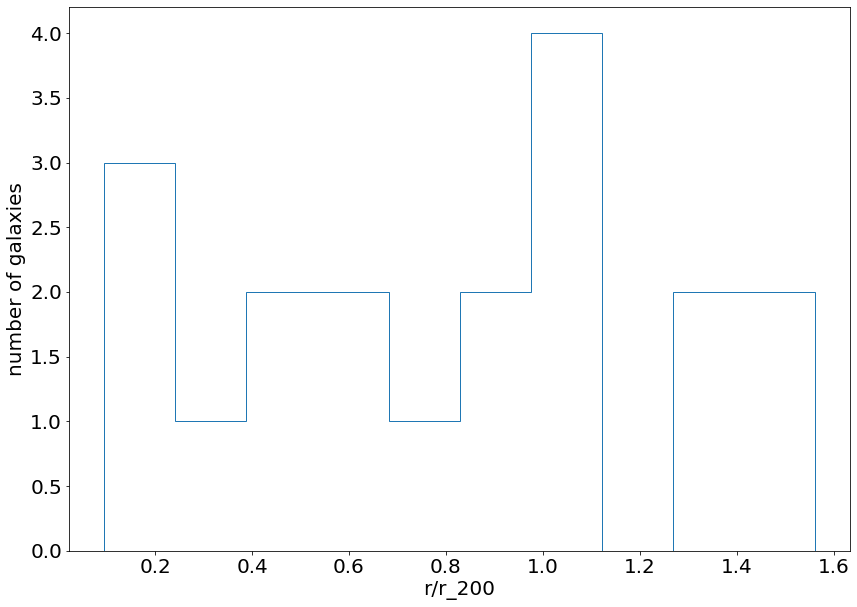

In [8]:
# lets test somo clean up by separation.
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# LzL = Slist['LZ_L'][()]

pl.figure(figsize=(14, 10))

pl.hist(dist, histtype='step')
pl.ylabel('number of galaxies')
pl.xlabel('r/r_200')

In [9]:
ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]
CosCen = CosCen[ir]
CosVel = CosVel[ir]
#LzL = LzL[ir]

Satellites.size, CosCen.min()

(14, -0.9617047452183579)

In [10]:
#all
size = Satellites.size

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv, CosRc, GASMasses, GASAbundances, temp, temp2 = [], [], [], [], [], []
# CosRv, CosRc, GASMasses, GASAbundances, temp = [], [], [], [], []
StarMass = []

for ff, cc in zip(Satellites, Centrals):
    #try:
    cosRv, cosRc, GasMasses, GasAbundances, ttemp, ttemp2 = getAllLastP(ff, cc)
#     cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
    passs += 1
    #except:
     #   C += 1
      #  continue
    
    CosRv.extend(list(cosRv))
    CosRc.extend(list(cosRc))
    GASMasses.extend(list(GasMasses))
    GASAbundances.extend(list(GasAbundances))
    temp.extend(list(ttemp))
    temp2.extend(list(ttemp2))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv, CosRc, GASMasses, GASAbundances = np.array(CosRv), np.array(CosRc), np.array(GASMasses), np.array(GASAbundances)
StarMass = np.array(StarMass)
temp = np.array(temp)
temp2 = np.array(temp2)
passs

100% (14 of 14) |########################| Elapsed Time: 0:03:17 ETA:  00:00:00

14

22025 22025


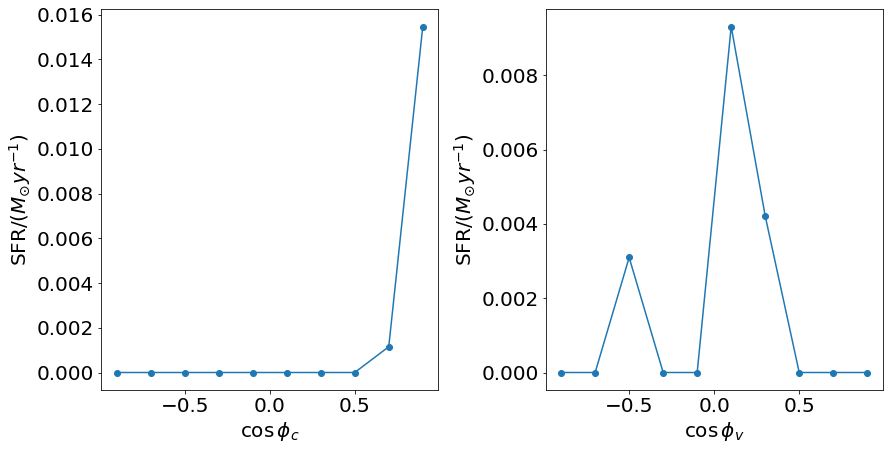

In [11]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.32)

Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

# data = GASMasses
weight = np.ones(temp.size)
# weight = 1./StarMass

data = temp
# weight = temp
# weight = np.ones(temp.size)
# data = np.log10((GASAbundances[:,4]/FeMass)/(GASAbundances[:,6]/HMass)) - NfeNhe_sun
# # data = data - temp # ok, both metallicities, now and then
# data = temp
# i = np.where((np.isinf(data)==False) & (np.isnan(data)==False))
# data = data[i]
# CosRc = CosRc[i]
# CosRv = CosRv[i]

#weight = np.ones(temp[i].size) # no weight

#weight = np.log10((GASAbundances[:,4]/FeMass)/(GASAbundances[:,6]/HMass)) - NfeNhe_sun
# weight = ((GASAbundances[:,4]/FeMass)/(GASAbundances[:,6]/HMass))
#i = np.where((np.isinf(weight)==False) & (np.isnan(weight)==False))
#weight = weight[i]
# miwe = weight.min()
# weight = weight - miwe # one will weight 0, but, well, *shrughs*

#CosRc = CosRc[i]
#CosRv = CosRv[i]

#data = temp2[i]

sumC, binsC, zipC = sp.binned_statistic(CosRc, data*weight, statistic='sum', bins=10, range=(-1.,1.))
sumV, binsV, zipV = sp.binned_statistic(CosRv, data*weight, statistic='sum', bins=10, range=(-1.,1.))

# WsumC, binsC, zipC = sp.binned_statistic(CosRc, weight, statistic='sum', bins=10, range=(-1.,1.))
# WsumV, binsV, zipV = sp.binned_statistic(CosRv, weight, statistic='sum', bins=10, range=(-1.,1.))

# sumC = sumC/WsumC
# sumV = sumV/WsumV

# sumCe = sumC[zipC-1]
# sumVe = sumV[zipV-1]

# stdC, binsC, zipC = sp.binned_statistic(CosRc, ((data-sumCe)*weight)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV, binsV, zipV = sp.binned_statistic(CosRv, ((data-sumVe)*weight)**2., statistic='sum', bins=10, range=(-1.,1.))

# numbC, binsC, zipC = sp.binned_statistic(CosRc, data, statistic='count', bins=10, range=(-1.,1.))
# numbV, binsV, zipV = sp.binned_statistic(CosRv, data, statistic='count', bins=10, range=(-1.,1.))

# errC = np.sqrt(numbC/((numbC-1.)*WsumC**2.)*stdC)
# errV = np.sqrt(numbV/((numbV-1.)*WsumV**2.)*stdV)

# sumC, binsC, zipC = sp.binned_statistic(CosRc, data*weight, statistic='median', bins=10, range=(-1.,1.))
# sumV, binsV, zipV = sp.binned_statistic(CosRv, data*weight, statistic='median', bins=10, range=(-1.,1.))

# errC = errC * np.sqrt(np.pi/2.)
# errV = errV * np.sqrt(np.pi/2.)

# bins should be the same
x_x = .5*(binsV[:-1]+binsV[1:])

pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')
pl.plot(x_x, sumC, marker='o')
# pl.legend(loc='best')

pl.xlabel('$\cos\,\phi_c$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
# pl.ylabel('[Fe/H]')
pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')
# pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)
 
# pl.errorbar(x_x, sumV, yerr=errV, marker='o')
pl.errorbar(x_x, sumV, marker='o')

pl.xlabel('$\cos\,\phi_v$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
# pl.ylabel('Gas Mass/Stellar Mass')
# pl.ylabel('[Fe/h]')
pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

print(data.size, weight.size)

# pl.savefig('paperGraphs/phiAll.pdf')

In [12]:
sumC[0]/14, sumV[0]/14
stu = np.unique(StarMass)
np.mean(stu)

0.04648212

In [13]:
# lets separate by Cosines
# CosCen = np.abs(CosCen)
# CosVel = np.abs(CosVel)

# medCen = np.median(CosCen)
# medVel = np.median(CosVel)

# errCen = np.std(CosCen)/np.sqrt(CosCen.size)
# errVel = np.std(CosVel)/np.sqrt(CosVel.size)

# print(medCen, medVel)
# print(errCen, errVel)

# i1Cen = np.where(CosCen<0.5)
# i2Cen = np.where(CosCen>0.5)

# i1Vel = np.where(CosVel<0.5)
# i2Vel = np.where(CosVel>0.5)

# satC1, centC1 = Satellites[i1Cen], Centrals[i1Cen]
# satC2, centC2 = Satellites[i2Cen], Centrals[i2Cen]

# satV1, centV1 = Satellites[i1Vel], Centrals[i1Vel]
# satV2, centV2 = Satellites[i2Vel], Centrals[i2Vel]

In [14]:
# # low cos central
# size = satC1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1, CosRc_C1, GASMasses_C1, GASAbundances_C1, temp_C1 = [], [], [], [], []
# StarMass_C1 = []

# for ff, cc in zip(satC1, centC1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1.extend(list(cosRv))
#     CosRc_C1.extend(list(cosRc))
#     GASMasses_C1.extend(list(GasMasses))
#     GASAbundances_C1.extend(list(GasAbundances))
#     temp_C1.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1, CosRc_C1, GASMasses_C1, GASAbundances_C1 = np.array(CosRv_C1), np.array(CosRc_C1), np.array(GASMasses_C1), np.array(GASAbundances_C1)
# StarMass_C1 = np.array(StarMass_C1)
# temp_C1 = np.array(temp_C1)
# passs

In [15]:
#  # high cos central
# size = satC2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2, CosRc_C2, GASMasses_C2, GASAbundances_C2, temp_C2 = [], [], [], [], []
# StarMass_C2 = []

# for ff, cc in zip(satC2, centC2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
#     CosRv_C2.extend(list(cosRv))
#     CosRc_C2.extend(list(cosRc))
#     GASMasses_C2.extend(list(GasMasses))
#     GASAbundances_C2.extend(list(GasAbundances))
#     temp_C2.extend(list(ttemp))
    
#      # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
#     StarMass_C2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2, CosRc_C2, GASMasses_C2, GASAbundances_C2 = np.array(CosRv_C2), np.array(CosRc_C2), np.array(GASMasses_C2), np.array(GASAbundances_C2)
# StarMass_C2 = np.array(StarMass_C2)
# temp_C2 = np.array(temp_C2)
# passs

In [16]:
# # low cos velocity
# size = satV1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1, CosRc_V1, GASMasses_V1, GASAbundances_V1, temp_V1 = [], [], [], [], []
# StarMass_V1 = []

# for ff, cc in zip(satV1, centV1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
#     CosRv_V1.extend(list(cosRv))
#     CosRc_V1.extend(list(cosRc))
#     GASMasses_V1.extend(list(GasMasses))
    
#     GASAbundances_V1.extend(list(GasAbundances))
#     temp_V1.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
#     StarMass_V1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1, CosRc_V1, GASMasses_V1, GASAbundances_V1 = np.array(CosRv_V1), np.array(CosRc_V1), np.array(GASMasses_V1), np.array(GASAbundances_V1)
# StarMass_V1 = np.array(StarMass_V1)
# temp_V1 = np.array(temp_V1)
# passs

In [17]:
# # low cos velocity
# size = satV2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2, CosRc_V2, GASMasses_V2, GASAbundances_V2, temp_V2 = [], [], [], [], []
# StarMass_V2 = []

# for ff, cc in zip(satV2, centV2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
#     CosRv_V2.extend(list(cosRv))
#     CosRc_V2.extend(list(cosRc))
#     GASMasses_V2.extend(list(GasMasses))
    
#     GASAbundances_V2.extend(list(GasAbundances))
#     temp_V2.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
#     StarMass_V2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2, CosRc_V2, GASMasses_V2, GASAbundances_V2 = np.array(CosRv_V2), np.array(CosRc_V2), np.array(GASMasses_V2), np.array(GASAbundances_V2)
# StarMass_V2 = np.array(StarMass_V2)
# temp_V2 = np.array(temp_V2)
# passs

In [18]:
# # cos C for both

# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.35)

# # sumC1, binsC1, zipC1 = sp.binned_statistic(CosRc_C1, GASAbundances_C1[:,5]/StarMass_C1, statistic='sum', bins=10, range=(-1.,1.))
# # sumC2, binsC2, zipC2 = sp.binned_statistic(CosRc_C2, GASAbundances_C2[:,5]/StarMass_C2, statistic='sum', bins=10, range=(-1.,1.))

# # sumV1, binsV1, zipV1 = sp.binned_statistic(CosRv_C1, GASAbundances_C1[:,5]/StarMass_C1, statistic='sum', bins=10, range=(-1.,1.))
# # sumV2, binsV2, zipV2 = sp.binned_statistic(CosRv_C2, GASAbundances_C2[:,5]/StarMass_C2, statistic='sum', bins=10, range=(-1.,1.))

# # data_C1 = GASAbundances_C1[:,5]
# # data_C2 = GASAbundances_C2[:,5]
# # weight_C1 = 1./StarMass_C1
# # weight_C2 = 1./StarMass_C2

# data_C1 = Cosmo.lookback_time(temp_C1).value
# data_C2 = Cosmo.lookback_time(temp_C2).value
# weight_C1 = np.ones(temp_C1.size)
# weight_C2 = np.ones(temp_C2.size)

# # data_C1 = np.log10((GASAbundances_C1[:,3]/OMass)/(GASAbundances_C1[:,4]/FeMass)) - NoNfe_sun
# # i_C1 = np.where((np.isinf(data_C1)==False) & (np.isnan(data_C1)==False))
# # data_C1 = data_C1[i_C1]
# # CosRc_C1 = CosRc_C1[i_C1]
# # CosRv_C1 = CosRv_C1[i_C1]
# # weight_C1 = np.ones(temp_C1[i_C1].size)

# # data_C2 = np.log10((GASAbundances_C2[:,3]/OMass)/(GASAbundances_C2[:,4]/FeMass)) - NoNfe_sun
# # i_C2 = np.where((np.isinf(data_C2)==False) & (np.isnan(data_C2)==False))
# # data_C2 = data_C2[i_C2]
# # CosRc_C2 = CosRc_C2[i_C2]
# # CosRv_C2 = CosRv_C2[i_C2]
# # weight_C2 = np.ones(temp_C2[i_C2].size)

# sumC1, binsC1, zipC1 = sp.binned_statistic(CosRc_C1, data_C1*weight_C1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2, binsC2, zipC2 = sp.binned_statistic(CosRc_C2, data_C2*weight_C2, statistic='sum', bins=10, range=(-1.,1.))
# sumV1, binsV1, zipV1 = sp.binned_statistic(CosRv_C1, data_C1*weight_C1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2, binsV2, zipV2 = sp.binned_statistic(CosRv_C2, data_C2*weight_C2, statistic='sum', bins=10, range=(-1.,1.))

# WsumC1, binsC1, zipC1 = sp.binned_statistic(CosRc_C1, weight_C1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC2, binsC2, zipC2 = sp.binned_statistic(CosRc_C2, weight_C2, statistic='sum', bins=10, range=(-1.,1.))
# WsumV1, binsV1, zipV1 = sp.binned_statistic(CosRv_C1, weight_C1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV2, binsV2, zipV2 = sp.binned_statistic(CosRv_C2, weight_C2, statistic='sum', bins=10, range=(-1.,1.))

# sumC1 = sumC1/WsumC1
# sumC2 = sumC2/WsumC2
# sumV1 = sumV1/WsumV1
# sumV2 = sumV2/WsumV2

# sumC1e = sumC1[zipC1-1]
# sumC2e = sumC2[zipC2-1]
# sumV1e = sumV1[zipV1-1]
# sumV2e = sumV2[zipV2-1]

# stdC1, binsC1, zipC1 = sp.binned_statistic(CosRc_C1, ((data_C1-sumC1e)*weight_C1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC2, binsC2, zipC2 = sp.binned_statistic(CosRc_C2, ((data_C2-sumC2e)*weight_C2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV1, binsV1, zipV1 = sp.binned_statistic(CosRv_C1, ((data_C1-sumV1e)*weight_C1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV2, binsV2, zipV2 = sp.binned_statistic(CosRv_C2, ((data_C2-sumV2e)*weight_C2)**2., statistic='sum', bins=10, range=(-1.,1.))

# numbC1, binsC1, zipC1 = sp.binned_statistic(CosRc_C1, data_C1, statistic='count', bins=10, range=(-1.,1.))
# numbC2, binsC2, zipC2 = sp.binned_statistic(CosRc_C2, data_C2, statistic='count', bins=10, range=(-1.,1.))
# numbV1, binsV1, zipV1 = sp.binned_statistic(CosRv_C1, data_C1, statistic='count', bins=10, range=(-1.,1.))
# numbV2, binsV2, zipV2 = sp.binned_statistic(CosRv_C2, data_C2, statistic='count', bins=10, range=(-1.,1.))

# errC1 = np.sqrt(numbC1/((numbC1-1.)*WsumC1**2.)*stdC1)
# errC2 = np.sqrt(numbC2/((numbC2-1.)*WsumC2**2.)*stdC2)
# errV1 = np.sqrt(numbV1/((numbV1-1.)*WsumV1**2.)*stdV1)
# errV2 = np.sqrt(numbV2/((numbV2-1.)*WsumV2**2.)*stdV2)

# # bins should be the same
# x_x = .5*(binsV2[:-1]+binsV2[1:])

# pl.subplot(1, 2, 1)

# # pl.plot(x_x, sumC1, marker='o', label='cos theta<0.5')
# # pl.plot(x_x, sumC2, marker='o', label='cos theta>0.5')

# pl.errorbar(x_x, sumC1, yerr=errC1, marker='o', label='cos theta<0.5')
# pl.errorbar(x_x, sumC2, yerr=errC2, marker='o', label='cos theta>0.5')


# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Time since stripping/Gyrs')
# #pl.ylabel('Delta Temperature/K')
# #pl.ylabel('[O/Fe]')

# pl.subplot(1, 2, 2)

# # pl.plot(x_x, sumV1, marker='o', label='cos theta<0.5')
# # pl.plot(x_x, sumV2, marker='o', label='cos theta>0.5')

# pl.errorbar(x_x, sumV1, yerr=errV1, marker='o', label='cos theta<0.5')
# pl.errorbar(x_x, sumV2, yerr=errV2, marker='o', label='cos theta>0.5')


# pl.xlabel('cos phi_v')
# pl.ylabel('Time since stripping/Gyrs')
# #pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')

In [19]:
# # cos V for both

# pl.figure(figsize=(14, 7))
# pl.subplots_adjust(wspace=0.35)
# # sumC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, GASAbundances_V1[:,5]/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
# # sumC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, GASAbundances_V2[:,5]/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# # sumV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, GASAbundances_V1[:,5]/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
# # sumV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, GASAbundances_V2[:,5]/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# # data_V1 = GASAbundances_V1[:,5]
# # data_V2 = GASAbundances_V2[:,5]
# # weight_V1 = 1./StarMass_V1
# # weight_V2 = 1./StarMass_V2

# data_V1 = Cosmo.lookback_time(temp_V1).value
# data_V2 = Cosmo.lookback_time(temp_V2).value
# weight_V1 = np.ones(temp_V1.size)
# weight_V2 = np.ones(temp_V2.size)

# # data_V1 = np.log10((GASAbundances_V1[:,3]/OMass)/(GASAbundances_V1[:,4]/FeMass)) - NoNfe_sun
# # i_V1 = np.where((np.isinf(data_V1)==False) & (np.isnan(data_V1)==False))
# # data_V1 = data_V1[i_V1]
# # CosRc_V1 = CosRc_V1[i_V1]
# # CosRv_V1 = CosRv_V1[i_V1]
# # weight_V1 = np.ones(temp_V1[i_V1].size)

# # data_V2 = np.log10((GASAbundances_V2[:,3]/OMass)/(GASAbundances_V2[:,4]/FeMass)) - NoNfe_sun
# # i_V2 = np.where((np.isinf(data_V2)==False) & (np.isnan(data_V2)==False))
# # data_V2 = data_V2[i_V2]
# # CosRc_V2 = CosRc_V2[i_V2]
# # CosRv_V2 = CosRv_V2[i_V2]
# # weight_V2 = np.ones(temp_V2[i_V2].size)

# sumC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, data_V1*weight_V1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, data_V2*weight_V2, statistic='sum', bins=10, range=(-1.,1.))
# sumV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, data_V1*weight_V1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, data_V2*weight_V2, statistic='sum', bins=10, range=(-1.,1.))

# WsumC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, weight_V1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, weight_V2, statistic='sum', bins=10, range=(-1.,1.))
# WsumV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, weight_V1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, weight_V2, statistic='sum', bins=10, range=(-1.,1.))

# sumC1_V = sumC1_V/WsumC1_V
# sumC2_V = sumC2_V/WsumC2_V
# sumV1_V = sumV1_V/WsumV1_V
# sumV2_V = sumV2_V/WsumV2_V

# sumC1e_V = sumC1_V[zipC1_V-1]
# sumC2e_V = sumC2_V[zipC2_V-1]
# sumV1e_V = sumV1_V[zipV1_V-1]
# sumV2e_V = sumV2_V[zipV2_V-1]

# stdC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, ((data_V1-sumC1e_V)*weight_V1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, ((data_V2-sumC2e_V)*weight_V2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, ((data_V1-sumV1e_V)*weight_V1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, ((data_V2-sumV2e_V)*weight_V2)**2., statistic='sum', bins=10, range=(-1.,1.))

# numbC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, data_V1, statistic='count', bins=10, range=(-1.,1.))
# numbC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, data_V2, statistic='count', bins=10, range=(-1.,1.))
# numbV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, data_V1, statistic='count', bins=10, range=(-1.,1.))
# numbV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, data_V2, statistic='count', bins=10, range=(-1.,1.))

# errC1_V = np.sqrt(numbC1_V/((numbC1_V-1.)*WsumC1_V**2.)*stdC1_V)
# errC2_V = np.sqrt(numbC2_V/((numbC2_V-1.)*WsumC2_V**2.)*stdC2_V)
# errV1_V = np.sqrt(numbV1_V/((numbV1_V-1.)*WsumV1_V**2.)*stdV1_V)
# errV2_V = np.sqrt(numbV2_V/((numbV2_V-1.)*WsumV2_V**2.)*stdV2_V)


# # bins should be the same
# x_x = .5*(binsV2_V[:-1]+binsV2_V[1:])

# pl.subplot(1, 2, 1)

# # pl.plot(x_x, sumC1_V, marker='o', label='cos theta_v<0.5')
# # pl.plot(x_x, sumC2_V, marker='o', label='cos theta_v>0.5')

# pl.errorbar(x_x, sumC1_V, yerr=errC1_V, marker='o', label='cos theta_v<0.5')
# pl.errorbar(x_x, sumC2_V, yerr=errC2_V, marker='o', label='cos theta_v>0.5')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Time since stripping/Gyrs')
# # pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')

# pl.subplot(1, 2, 2)

# # pl.plot(x_x, sumV1_V, marker='o', label='cos theta<0.5')
# # pl.plot(x_x, sumV2_V, marker='o', label='cos theta>0.5')

# pl.errorbar(x_x, sumV1_V, yerr=errV1_V, marker='o', label='cos theta<0.5')
# pl.errorbar(x_x, sumV2_V, yerr=errV2_V, marker='o', label='cos theta>0.5')

# pl.xlabel('cos phi_v')
# pl.ylabel('Time since stripping/Gyrs')
# # pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')

In [20]:
# # lets separate galaxies between those that are moving toward the center and away the center.
# # dk if time is important, maybe separation 2 is between firts enter and backplashes.

# def sepPosC(ff, cc):
#     velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][ff]
#     velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][cc]
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][ff]
#     posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
#     velT = velCen - velGal
#     cendD = posCen - posGal
    
#     nVel = np.sqrt(velT[0]**2.+velT[1]**2.+velT[2]**2.)
#     ncenD = np.sqrt(cendD[0]**2.+cendD[1]**2.+cendD[2]**2.)
    
#     ndot = velT[0]*cendD[0] + velT[1]*cendD[1] + velT[2]*cendD[2]
#     cosB = ndot/(nVel*ncenD)
#     return cosB

In [21]:
# cosBC1 = []
# for ff, cc in zip(satC1, centC1):
#     cb = sepPosC(ff, cc)
#     cosBC1.append(cb)
    
# cosBC1 = np.array(cosBC1)

# cosBC2 = []
# for ff, cc in zip(satC2, centC2):
#     cb = sepPosC(ff, cc)
#     cosBC2.append(cb)
    
# cosBC2 = np.array(cosBC2)

# cosBV1 = []
# for ff, cc in zip(satV1, centV1):
#     cb = sepPosC(ff, cc)
#     cosBV1.append(cb)
    
# cosBV1 = np.array(cosBV1)

# cosBV2 = []
# for ff, cc in zip(satV2, centV2):
#     cb = sepPosC(ff, cc)
#     cosBV2.append(cb)
    
# cosBV2 = np.array(cosBV2)

In [22]:
# allCB = list(cosBC1)
# allCB.extend(list(cosBC2))
# allCB = np.array(allCB)

# pl.figure(figsize=(14,7))

# pl.hist(allCB, bins=2)

In [23]:
# iC1_1 = np.where(cosBC1<0.)
# iC1_2 = np.where(cosBC1>0.)

# iC2_1 = np.where(cosBC2<0.)
# iC2_2 = np.where(cosBC2>0.)

# iV1_1 = np.where(cosBV1<0.)
# iV1_2 = np.where(cosBV1>0.)

# iV2_1 = np.where(cosBV2<0.)
# iV2_2 = np.where(cosBV2>0.)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

In [24]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# passs

In [25]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# passs

In [26]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# passs

In [27]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# passs

In [28]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# passs

In [29]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# passs

In [30]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# passs

In [31]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# passs

In [32]:
# # cos C for both

# pl.figure(figsize=(14, 7))

# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 infall')
# pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 outfall')
# pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 infall')
# pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 outfall')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 infall')
# pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 outfall')
# pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 infall')
# pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 outfall')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')

In [33]:
# # cos V for both

# pl.figure(figsize=(14, 7))

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 infall')
# pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 outfall')
# pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 infall')
# pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 outfall')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 infall')
# pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 outfall')

# pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 infall')
# pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 outfall')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')


In [34]:
# # equal as important as the time, is the time that they are now, i gonna test galaxies that are not backsplashed
# def getBack(ff, cc):
#     uniqueID = int(128*1e6+ff)
#     stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
#     uniqueC = int(128*1e6+cc)
#     streeC = networkx.dfs_tree(trees, str(uniqueC))
#     mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
#     dist = []
    
#     for mm, mC in zip(mtree, mtreeC):
#         snap, idd = split_unique_id(int(mm))
#         snapC, iddC = split_unique_id(int(mC))
#         if snap==snapC:
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
#             posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
#             dif = posGal - posCen
#             dd = np.sqrt(np.sum(dif**2))
#             dist.append(dd)

#     dist = np.array(dist)
#     t = False
#     if dist.min() != dist[0]:
#         t = True
#     return t

In [35]:
# cosBC1 = []
# for ff, cc in zip(satC1, centC1):
#     cb = getBack(ff, cc)
#     cosBC1.append(cb)
    
# cosBC1 = np.array(cosBC1)

# cosBC2 = []
# for ff, cc in zip(satC2, centC2):
#     cb = getBack(ff, cc)
#     cosBC2.append(cb)
    
# cosBC2 = np.array(cosBC2)

# cosBV1 = []
# for ff, cc in zip(satV1, centV1):
#     cb = getBack(ff, cc)
#     cosBV1.append(cb)
    
# cosBV1 = np.array(cosBV1)

# cosBV2 = []
# for ff, cc in zip(satV2, centV2):
#     cb = getBack(ff, cc)
#     cosBV2.append(cb)
    
# cosBV2 = np.array(cosBV2)

In [36]:
# iC1_1 = np.where(cosBC1==False)
# iC1_2 = np.where(cosBC1)

# iC2_1 = np.where(cosBC2==False)
# iC2_2 = np.where(cosBC2)

# iV1_1 = np.where(cosBV1==False)
# iV1_2 = np.where(cosBV1)

# iV2_1 = np.where(cosBV2==False)
# iV2_2 = np.where(cosBV2)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

In [37]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# passs

In [38]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# passs

In [39]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# passs

In [40]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# passs

In [41]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# passs

In [42]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# passs

In [43]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# passs

In [44]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# passs

In [45]:
# pl.figure(figsize=(14, 7))

# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 1st infall')
# pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 backsplash')
# pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 1st infall')
# pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 1st infall')
# pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 backsplash')
# pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 1st infall')
# pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')

In [46]:

# pl.figure(figsize=(14, 7))

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
# pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 backsplash')

# pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')


In [47]:
# i gonna try a new definition of infall vs backslash, more loose in the end. lest see
# how I done this in the first place.
# equal as important as the time, is the time that they are now, i gonna test galaxies that are not backsplashed
def getBack_2nd(ff, cc):
    uniqueID = int(128*1e6+ff)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueC = int(128*1e6+cc)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    dist = []
    
    for mm, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mC))
        if snap==snapC:
            posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
            grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
            R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]
            dif = posGal - posCen
            dd = np.sqrt(np.sum(dif**2))
            d200 = dd/R200
            if d200<1.5: #at each ponit test if is at least at 1.5r_200.
                dist.append(dd)

    dist = np.array(dist)
    
    # ok, we have the dist. lets see if has changed too much
    t = False
    for i, d in enumerate(dist[1:]):
        if d<dist[i]: # at some point was closer than a nearer redshift
            t = True
            
    return t

In [48]:
# cosBC1 = []
# for ff, cc in zip(satC1, centC1):
#     cb = getBack_2nd(ff, cc)
#     cosBC1.append(cb)
    
# cosBC1 = np.array(cosBC1)

# cosBC2 = []
# for ff, cc in zip(satC2, centC2):
#     cb = getBack_2nd(ff, cc)
#     cosBC2.append(cb)
    
# cosBC2 = np.array(cosBC2)

# cosBV1 = []
# for ff, cc in zip(satV1, centV1):
#     cb = getBack_2nd(ff, cc)
#     cosBV1.append(cb)
    
# cosBV1 = np.array(cosBV1)

# cosBV2 = []
# for ff, cc in zip(satV2, centV2):
#     cb = getBack_2nd(ff, cc)
#     cosBV2.append(cb)
    
# cosBV2 = np.array(cosBV2)

In [49]:
# iC1_1 = np.where(cosBC1==False)
# iC1_2 = np.where(cosBC1)

# iC2_1 = np.where(cosBC2==False)
# iC2_2 = np.where(cosBC2)

# iV1_1 = np.where(cosBV1==False)
# iV1_2 = np.where(cosBV1)

# iV2_1 = np.where(cosBV2==False)
# iV2_2 = np.where(cosBV2)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

In [50]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1, temp_C1_1 = [], [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
#     temp_C1_1.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# temp_C1_1 = np.array(temp_C1_1)

# passs

In [51]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2, temp_C1_2 = [], [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
#     temp_C1_2.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# temp_C1_2 = np.array(temp_C1_2)

# passs

In [52]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1, temp_C2_1 = [], [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
#     temp_C2_1.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# temp_C2_1 = np.array(temp_C2_1)

# passs

In [53]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2, temp_C2_2 = [], [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
#     temp_C2_2.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# temp_C2_2 = np.array(temp_C2_2)

# passs

In [54]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1, temp_V1_1 = [], [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
#     temp_V1_1.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# temp_V1_1 = np.array(temp_V1_1)

# passs

In [55]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2, temp_V1_2 = [], [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
#     temp_V1_2.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# temp_V1_2 = np.array(temp_V1_2)

# passs

In [56]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1, temp_V2_1 = [], [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
#     temp_V2_1.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# temp_V2_1 = np.array(temp_V2_1)
# passs

In [57]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2, temp_V2_2 = [], [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
#     temp_V2_2.extend(list(ttemp))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# temp_V2_2 = np.array(temp_V2_2)
# passs

In [58]:
# pl.figure(figsize=(14, 7))
# pl.subplots_adjust(wspace=0.35)
# # sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASAbundances_C1_1[:,5]/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# # sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASAbundances_C2_1[:,5]/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# # sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASAbundances_C1_1[:,5]/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# # sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASAbundances_C2_1[:,5]/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# # sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASAbundances_C1_2[:,5]/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# # sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASAbundances_C2_2[:,5]/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASAbundances_C1_2[:,5]/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# # sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASAbundances_C2_2[:,5]/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # data_C1_1 = GASAbundances_C1_1[:,5]
# # data_C2_1 = GASAbundances_C2_1[:,5]
# # data_C1_2 = GASAbundances_C1_2[:,5]
# # data_C2_2 = GASAbundances_C2_2[:,5]

# # weight_C1_1 = 1./StarMass_C1_1
# # weight_C2_1 = 1./StarMass_C2_1
# # weight_C1_2 = 1./StarMass_C1_2
# # weight_C2_2 = 1./StarMass_C2_2


# data_C1_1 = Cosmo.lookback_time(temp_C1_1).value
# data_C2_1 = Cosmo.lookback_time(temp_C2_1).value
# data_C1_2 = Cosmo.lookback_time(temp_C1_2).value
# data_C2_2 = Cosmo.lookback_time(temp_C2_2).value

# weight_C1_1 = np.ones(temp_C1_1.size)
# weight_C2_1 = np.ones(temp_C2_1.size)
# weight_C1_2 = np.ones(temp_C1_2.size)
# weight_C2_2 = np.ones(temp_C2_2.size)


# # data_C1_1 = np.log10((GASAbundances_C1_1[:,3]/OMass)/(GASAbundances_C1_1[:,4]/FeMass)) - NoNfe_sun
# # i_C1_1 = np.where((np.isinf(data_C1_1)==False) & (np.isnan(data_C1_1)==False))
# # data_C1_1 = data_C1_1[i_C1_1]
# # CosRc_C1_1 = CosRc_C1_1[i_C1_1]
# # CosRv_C1_1 = CosRv_C1_1[i_C1_1]
# # weight_C1_1 = np.ones(temp_C1_1[i_C1_1].size)

# # data_C1_2 = np.log10((GASAbundances_C1_2[:,3]/OMass)/(GASAbundances_C1_2[:,4]/FeMass)) - NoNfe_sun
# # i_C1_2 = np.where((np.isinf(data_C1_2)==False) & (np.isnan(data_C1_2)==False))
# # data_C1_2 = data_C1_2[i_C1_2]
# # CosRc_C1_2 = CosRc_C1_2[i_C1_2]
# # CosRv_C1_2 = CosRv_C1_2[i_C1_2]
# # weight_C1_2 = np.ones(temp_C1_2[i_C1_2].size)

# # data_C2_1 = np.log10((GASAbundances_C2_1[:,3]/OMass)/(GASAbundances_C2_1[:,4]/FeMass)) - NoNfe_sun
# # i_C2_1 = np.where((np.isinf(data_C2_1)==False) & (np.isnan(data_C2_1)==False))
# # data_C2_1 = data_C2_1[i_C2_1]
# # CosRc_C2_1 = CosRc_C2_1[i_C2_1]
# # CosRv_C2_1 = CosRv_C2_1[i_C2_1]
# # weight_C2_1 = np.ones(temp_C2_1[i_C2_1].size)

# # data_C2_2 = np.log10((GASAbundances_C2_2[:,3]/OMass)/(GASAbundances_C2_2[:,4]/FeMass)) - NoNfe_sun
# # i_C2_2 = np.where((np.isinf(data_C2_2)==False) & (np.isnan(data_C2_2)==False))
# # data_C2_2 = data_C2_2[i_C2_2]
# # CosRc_C2_2 = CosRc_C2_2[i_C2_2]
# # CosRv_C2_2 = CosRv_C2_2[i_C2_2]
# # weight_C2_2 = np.ones(temp_C2_2[i_C2_2].size)


# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, data_C1_1*weight_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, data_C2_1*weight_C2_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, data_C1_2*weight_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, data_C2_2*weight_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, data_C1_1*weight_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, data_C2_1*weight_C2_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, data_C1_2*weight_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, data_C2_2*weight_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# WsumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, weight_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, weight_C2_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, weight_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# WsumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, weight_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# WsumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, weight_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, weight_C2_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, weight_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# WsumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, weight_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumC1_1 = sumC1_1/WsumC1_1
# sumC2_1 = sumC2_1/WsumC2_1
# sumC1_2 = sumC1_2/WsumC1_2
# sumC2_2 = sumC2_2/WsumC2_2

# sumV1_1 = sumV1_1/WsumV1_1
# sumV2_1 = sumV2_1/WsumV2_1
# sumV1_2 = sumV1_2/WsumV1_2
# sumV2_2 = sumV2_2/WsumV2_2

# sumC1e_1 = sumC1_1[zipC1_1-1]
# sumC2e_1 = sumC2_1[zipC2_1-1]
# sumC1e_2 = sumC1_2[zipC1_2-1]
# sumC2e_2 = sumC2_2[zipC2_2-1]

# sumV1e_1 = sumV1_1[zipV1_1-1]
# sumV2e_1 = sumV2_1[zipV2_1-1]
# sumV1e_2 = sumV1_2[zipV1_2-1]
# sumV2e_2 = sumV2_2[zipV2_2-1]

# stdC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, ((data_C1_1-sumC1e_1)*weight_C1_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, ((data_C2_1-sumC2e_1)*weight_C2_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, ((data_C1_2-sumC1e_2)*weight_C1_2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, ((data_C2_2-sumC2e_2)*weight_C2_2)**2., statistic='sum', bins=10, range=(-1.,1.))

# stdV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, ((data_C1_1-sumV1e_1)*weight_C1_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, ((data_C2_1-sumV2e_1)*weight_C2_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, ((data_C1_2-sumV1e_2)*weight_C1_2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, ((data_C2_2-sumV2e_2)*weight_C2_2)**2., statistic='sum', bins=10, range=(-1.,1.))

# numbC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, data_C1_1, statistic='count', bins=10, range=(-1.,1.))
# numbC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, data_C2_1, statistic='count', bins=10, range=(-1.,1.))
# numbC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, data_C1_2, statistic='count', bins=10, range=(-1.,1.))
# numbC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, data_C2_2, statistic='count', bins=10, range=(-1.,1.))

# numbV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, data_C1_1, statistic='count', bins=10, range=(-1.,1.))
# numbV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, data_C2_1, statistic='count', bins=10, range=(-1.,1.))
# numbV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, data_C1_2, statistic='count', bins=10, range=(-1.,1.))
# numbV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, data_C2_2, statistic='count', bins=10, range=(-1.,1.))

# errC1_1 = np.sqrt(numbC1_1/((numbC1_1-1.)*WsumC1_1**2.)*stdC1_1)
# errC2_1 = np.sqrt(numbC2_1/((numbC2_1-1.)*WsumC2_1**2.)*stdC2_1)
# errC1_2 = np.sqrt(numbC1_2/((numbC1_2-1.)*WsumC1_2**2.)*stdC1_2)
# errC2_2 = np.sqrt(numbC2_2/((numbC2_2-1.)*WsumC2_2**2.)*stdC2_2)

# errV1_1 = np.sqrt(numbV1_1/((numbV1_1-1.)*WsumV1_1**2.)*stdV1_1)
# errV2_1 = np.sqrt(numbV2_1/((numbV2_1-1.)*WsumV2_1**2.)*stdV2_1)
# errV1_2 = np.sqrt(numbV1_2/((numbV1_2-1.)*WsumV1_2**2.)*stdV1_2)
# errV2_2 = np.sqrt(numbV2_2/((numbV2_2-1.)*WsumV2_2**2.)*stdV2_2)

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# # pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 1st infall')
# # pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 backsplash')
# # pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 1st infall')
# # pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.errorbar(x_x, sumC1_1, yerr=errC1_1, marker='o', label='cos theta<0.5 1st infall')
# pl.errorbar(x_x, sumC1_2, yerr=errC1_2, marker='o', label='cos theta<0.5 backsplash')
# pl.errorbar(x_x, sumC2_1, yerr=errC2_1, marker='o', label='cos theta>0.5 1st infall')
# pl.errorbar(x_x, sumC2_2, yerr=errC2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Time since stripping/Gyrs')
# # pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')

# pl.subplot(1, 2, 2)

# # pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 1st infall')
# # pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 backsplash')
# # pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 1st infall')
# # pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.errorbar(x_x, sumV1_1, yerr=errV1_1, marker='o', label='cos theta<0.5 1st infall')
# pl.errorbar(x_x, sumV1_2, yerr=errV1_2, marker='o', label='cos theta<0.5 backsplash')
# pl.errorbar(x_x, sumV2_1, yerr=errV2_1, marker='o', label='cos theta>0.5 1st infall')
# pl.errorbar(x_x, sumV2_2, yerr=errV2_2, marker='o', label='cos theta>0.5 backsplash')

# pl.xlabel('cos phi_v')
# pl.ylabel('Time since stripping/Gyrs')
# # pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')

In [59]:

# pl.figure(figsize=(14, 7))
# pl.subplots_adjust(wspace=0.35)
# # sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASAbundances_V1_1[:,5]/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# # sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASAbundances_V2_1[:,5]/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# # sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASAbundances_V1_2[:,5]/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# # sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASAbundances_V2_2[:,5]/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASAbundances_V1_1[:,5]/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# # sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASAbundances_V2_1[:,5]/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# # sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASAbundances_V1_2[:,5]/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# # sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASAbundances_V2_2[:,5]/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))

# # data_V1_1 = GASAbundances_V1_1[:,5]
# # data_V2_1 = GASAbundances_V2_1[:,5]
# # data_V1_2 = GASAbundances_V1_2[:,5]
# # data_V2_2 = GASAbundances_V2_2[:,5]

# # weight_V1_1 = 1./StarMass_V1_1
# # weight_V2_1 = 1./StarMass_V2_1
# # weight_V1_2 = 1./StarMass_V1_2
# # weight_V2_2 = 1./StarMass_V2_2

# data_V1_1 = Cosmo.lookback_time(temp_V1_1).value
# data_V2_1 = Cosmo.lookback_time(temp_V2_1).value
# data_V1_2 = Cosmo.lookback_time(temp_V1_2).value
# data_V2_2 = Cosmo.lookback_time(temp_V2_2).value

# weight_V1_1 = np.ones(temp_V1_1.size)
# weight_V2_1 = np.ones(temp_V2_1.size)
# weight_V1_2 = np.ones(temp_V1_2.size)
# weight_V2_2 = np.ones(temp_V2_2.size)

# # data_V1_1 = np.log10((GASAbundances_V1_1[:,3]/OMass)/(GASAbundances_V1_1[:,4]/FeMass)) - NoNfe_sun
# # i_V1_1 = np.where((np.isinf(data_V1_1)==False) & (np.isnan(data_V1_1)==False))
# # data_V1_1 = data_V1_1[i_V1_1]
# # CosRc_V1_1 = CosRc_V1_1[i_V1_1]
# # CosRv_V1_1 = CosRv_V1_1[i_V1_1]
# # weight_V1_1 = np.ones(temp_V1_1[i_V1_1].size)

# # data_V1_2 = np.log10((GASAbundances_V1_2[:,3]/OMass)/(GASAbundances_V1_2[:,4]/FeMass)) - NoNfe_sun
# # i_V1_2 = np.where((np.isinf(data_V1_2)==False) & (np.isnan(data_V1_2)==False))
# # data_V1_2 = data_V1_2[i_V1_2]
# # CosRc_V1_2 = CosRc_V1_2[i_V1_2]
# # CosRv_V1_2 = CosRv_V1_2[i_V1_2]
# # weight_V1_2 = np.ones(temp_V1_2[i_V1_2].size)

# # data_V2_1 = np.log10((GASAbundances_V2_1[:,3]/OMass)/(GASAbundances_V2_1[:,4]/FeMass)) - NoNfe_sun
# # i_V2_1 = np.where((np.isinf(data_V2_1)==False) & (np.isnan(data_V2_1)==False))
# # data_V2_1 = data_V2_1[i_V2_1]
# # CosRc_V2_1 = CosRc_V2_1[i_V2_1]
# # CosRv_V2_1 = CosRv_V2_1[i_V2_1]
# # weight_V2_1 = np.ones(temp_V2_1[i_V2_1].size)

# # data_V2_2 = np.log10((GASAbundances_V2_2[:,3]/OMass)/(GASAbundances_V2_2[:,4]/FeMass)) - NoNfe_sun
# # i_V2_2 = np.where((np.isinf(data_V2_2)==False) & (np.isnan(data_V2_2)==False))
# # data_V2_2 = data_V2_2[i_V2_2]
# # CosRc_V2_2 = CosRc_V2_2[i_V2_2]
# # CosRv_V2_2 = CosRv_V2_2[i_V2_2]
# # weight_V2_2 = np.ones(temp_V2_2[i_V2_2].size)

# # print(CosRc_V1_2.shape, data_V1_2.shape, weight_V1_2.shape)

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, data_V1_1*weight_V1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, data_V2_1*weight_V2_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, data_V1_2*weight_V1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, data_V2_2*weight_V2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, data_V1_1*weight_V1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, data_V2_1*weight_V2_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, data_V1_2*weight_V1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, data_V2_2*weight_V2_2, statistic='sum', bins=10, range=(-1.,1.))

# WsumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, weight_V1_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, weight_V2_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, weight_V1_2, statistic='sum', bins=10, range=(-1.,1.))
# WsumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, weight_V2_2, statistic='sum', bins=10, range=(-1.,1.))

# WsumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, weight_V1_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, weight_V2_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, weight_V1_2, statistic='sum', bins=10, range=(-1.,1.))
# WsumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, weight_V2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumC1_V_1 = sumC1_V_1/WsumC1_V_1
# sumC2_V_1 = sumC2_V_1/WsumC2_V_1
# sumC1_V_2 = sumC1_V_2/WsumC1_V_2
# sumC2_V_2 = sumC2_V_2/WsumC2_V_2

# sumV1_V_1 = sumV1_V_1/WsumV1_V_1
# sumV2_V_1 = sumV2_V_1/WsumV2_V_1
# sumV1_V_2 = sumV1_V_2/WsumV1_V_2
# sumV2_V_2 = sumV2_V_2/WsumV2_V_2

# sumC1e_V_1 = sumC1_V_1[zipC1_V_1-1]
# sumC2e_V_1 = sumC2_V_1[zipC2_V_1-1]
# sumC1e_V_2 = sumC1_V_2[zipC1_V_2-1]
# sumC2e_V_2 = sumC2_V_2[zipC2_V_2-1]

# sumV1e_V_1 = sumV1_V_1[zipV1_V_1-1]
# sumV2e_V_1 = sumV2_V_1[zipV2_V_1-1]
# sumV1e_V_2 = sumV1_V_2[zipV1_V_2-1]
# sumV2e_V_2 = sumV2_V_2[zipV2_V_2-1]

# stdC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, ((data_V1_1-sumC1e_V_1)*weight_V1_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, ((data_V2_1-sumC2e_V_1)*weight_V2_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, ((data_V1_2-sumC1e_V_2)*weight_V1_2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, ((data_V2_2-sumC2e_V_2)*weight_V2_2)**2., statistic='sum', bins=10, range=(-1.,1.))

# stdV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, ((data_V1_1-sumV1e_V_1)*weight_V1_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, ((data_V2_1-sumV2e_V_1)*weight_V2_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, ((data_V1_2-sumV1e_V_2)*weight_V1_2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, ((data_V2_2-sumV2e_V_2)*weight_V2_2)**2., statistic='sum', bins=10, range=(-1.,1.))

# numbC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, data_V1_1, statistic='count', bins=10, range=(-1.,1.))
# numbC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, data_V2_1, statistic='count', bins=10, range=(-1.,1.))
# numbC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, data_V1_2, statistic='count', bins=10, range=(-1.,1.))
# numbC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, data_V2_2, statistic='count', bins=10, range=(-1.,1.))

# numbV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, data_V1_1, statistic='count', bins=10, range=(-1.,1.))
# numbV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, data_V2_1, statistic='count', bins=10, range=(-1.,1.))
# numbV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, data_V1_2, statistic='count', bins=10, range=(-1.,1.))
# numbV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, data_V2_2, statistic='count', bins=10, range=(-1.,1.))

# errC1_V_1 = np.sqrt(numbC1_V_1/((numbC1_V_1-1.)*WsumC1_V_1**2.)*stdC1_V_1)
# errC2_V_1 = np.sqrt(numbC2_V_1/((numbC2_V_1-1.)*WsumC2_V_1**2.)*stdC2_V_1)
# errC1_V_2 = np.sqrt(numbC1_V_2/((numbC1_V_2-1.)*WsumC1_V_2**2.)*stdC1_V_2)
# errC2_V_2 = np.sqrt(numbC2_V_2/((numbC2_V_2-1.)*WsumC2_V_2**2.)*stdC2_V_2)

# errV1_V_1 = np.sqrt(numbV1_V_1/((numbV1_V_1-1.)*WsumV1_V_1**2.)*stdV1_V_1)
# errV2_V_1 = np.sqrt(numbV2_V_1/((numbV2_V_1-1.)*WsumV2_V_1**2.)*stdV2_V_1)
# errV1_V_2 = np.sqrt(numbV1_V_2/((numbV1_V_2-1.)*WsumV1_V_2**2.)*stdV1_V_2)
# errV2_V_2 = np.sqrt(numbV2_V_2/((numbV2_V_2-1.)*WsumV2_V_2**2.)*stdV2_V_2)



# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# # pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# # pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
# # pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# # pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.errorbar(x_x, sumC1_V_1, yerr=errC1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# pl.errorbar(x_x, sumC1_V_2, yerr=errC1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
# pl.errorbar(x_x, sumC2_V_1, yerr=errC2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# pl.errorbar(x_x, sumC2_V_2, yerr=errC2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Time since stripping/Gyrs')
# # pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')

# pl.subplot(1, 2, 2)

# # pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# # pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
# # pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# # pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.errorbar(x_x, sumV1_V_1, yerr=errV1_V_1, marker='o', label='cos theta_v<0.5 1st infall')
# pl.errorbar(x_x, sumV1_V_2, yerr=errV1_V_2, marker='o', label='cos theta_v<0.5 backsplash')
# pl.errorbar(x_x, sumV2_V_1, yerr=errV2_V_1, marker='o', label='cos theta_v>0.5 1st infall')
# pl.errorbar(x_x, sumV2_V_2, yerr=errV2_V_2, marker='o', label='cos theta_v>0.5 backsplash')

# pl.xlabel('cos phi_v')
# pl.ylabel('Time since stripping/Gyrs')
# # pl.ylabel('[O/Fe]')
# #pl.ylabel('Delta Temperature/K')


In [60]:
# # ok, lets see time of infall, because this is kinda weird

# def getZin(ff, cc):
#     uniqueID = int(128*1e6+ff)
#     stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
#     uniqueC = int(128*1e6+cc)
#     streeC = networkx.dfs_tree(trees, str(uniqueC))
#     mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
#     z = np.inf
    
#     for mm, mC in zip(mtree, mtreeC):
#         snap, idd = split_unique_id(int(mm))
#         snapC, iddC = split_unique_id(int(mC))
#         if snap==snapC:
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
#             posCen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
#             grou = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
#             R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][grou]
#             dif = posGal - posCen
#             dd = np.sqrt(np.sum(dif**2))
#             d200 = dd/R200
#             if d200<1.5: #at some point
#                 z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            
#     return z

In [61]:
# zinC1 = []
# for ff, cc in zip(satC1, centC1):
#     zt = getZin(ff, cc)
#     zinC1.append(zt)
    
# zinC1 = np.array(zinC1)

# zinC2 = []
# for ff, cc in zip(satC2, centC2):
#     zt = getZin(ff, cc)
#     zinC2.append(zt)
    
# zinC2 = np.array(zinC2)

# zinV1 = []
# for ff, cc in zip(satV1, centV1):
#     zt = getZin(ff, cc)
#     zinV1.append(zt)
    
# zinV1 = np.array(zinV1)

# zinV2 = []
# for ff, cc in zip(satV2, centV2):
#     zt = getZin(ff, cc)
#     zinV2.append(zt)
    
# zinV2 = np.array(zinV2)

In [62]:
# OmegaM = sim['SnapNumber_128/Header/Omega0'][()]
# Cosmo = apc.FlatLambdaCDM(H0=100, Om0=OmegaM) 

# zinC1 = Cosmo.lookback_time(zinC1).value
# zinC2 = Cosmo.lookback_time(zinC2).value

# zinV1 = Cosmo.lookback_time(zinV1).value
# zinV2 = Cosmo.lookback_time(zinV2).value

# Z = list(zinC1)
# Z.extend(list(zinC2))
# Z.extend(list(zinV1))
# Z.extend(list(zinV2))

# zmed = np.median(Z)

# iC1_1 = np.where(zinC1<zmed)
# iC1_2 = np.where(zinC1>zmed)

# iC2_1 = np.where(zinC2<zmed)
# iC2_2 = np.where(zinC2>zmed)

# iV1_1 = np.where(zinV1<zmed)
# iV1_2 = np.where(zinV1>zmed)

# iV2_1 = np.where(zinV2<zmed)
# iV2_2 = np.where(zinV2>zmed)

# satC1_1, centC1_1 = satC1[iC1_1], centC1[iC1_1]
# satC1_2, centC1_2 = satC1[iC1_2], centC1[iC1_2]

# satC2_1, centC2_1 = satC2[iC2_1], centC2[iC2_1]
# satC2_2, centC2_2 = satC2[iC2_2], centC2[iC2_2]

# satV1_1, centV1_1 = satV1[iV1_1], centV1[iV1_1]
# satV1_2, centV1_2 = satV1[iV1_2], centV1[iV1_2]

# satV2_1, centV2_1 = satV2[iV2_1], centV2[iV2_1]
# satV2_2, centV2_2 = satV2[iV2_2], centV2[iV2_2]

# zmed

In [63]:
# # low cos central
# size = satC1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = [], [], [], []
# StarMass_C1_1 = []

# for ff, cc in zip(satC1_1, centC1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_1.extend(list(cosRv))
#     CosRc_C1_1.extend(list(cosRc))
#     GASMasses_C1_1.extend(list(GasMasses))
#     GASAbundances_C1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_1, CosRc_C1_1, GASMasses_C1_1, GASAbundances_C1_1 = np.array(CosRv_C1_1), np.array(CosRc_C1_1), np.array(GASMasses_C1_1), np.array(GASAbundances_C1_1)
# StarMass_C1_1 = np.array(StarMass_C1_1)
# passs

In [64]:
# # low cos central
# size = satC1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = [], [], [], []
# StarMass_C1_2 = []

# for ff, cc in zip(satC1_2, centC1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C1_2.extend(list(cosRv))
#     CosRc_C1_2.extend(list(cosRc))
#     GASMasses_C1_2.extend(list(GasMasses))
#     GASAbundances_C1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C1_2, CosRc_C1_2, GASMasses_C1_2, GASAbundances_C1_2 = np.array(CosRv_C1_2), np.array(CosRc_C1_2), np.array(GASMasses_C1_2), np.array(GASAbundances_C1_2)
# StarMass_C1_2 = np.array(StarMass_C1_2)
# passs

In [65]:
# # low cos central
# size = satC2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = [], [], [], []
# StarMass_C2_1 = []

# for ff, cc in zip(satC2_1, centC2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_1.extend(list(cosRv))
#     CosRc_C2_1.extend(list(cosRc))
#     GASMasses_C2_1.extend(list(GasMasses))
#     GASAbundances_C2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_1, CosRc_C2_1, GASMasses_C2_1, GASAbundances_C2_1 = np.array(CosRv_C2_1), np.array(CosRc_C2_1), np.array(GASMasses_C2_1), np.array(GASAbundances_C2_1)
# StarMass_C2_1 = np.array(StarMass_C2_1)
# passs

In [66]:
# # low cos central
# size = satC2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = [], [], [], []
# StarMass_C2_2 = []

# for ff, cc in zip(satC2_2, centC2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_C2_2.extend(list(cosRv))
#     CosRc_C2_2.extend(list(cosRc))
#     GASMasses_C2_2.extend(list(GasMasses))
#     GASAbundances_C2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_C2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_C2_2, CosRc_C2_2, GASMasses_C2_2, GASAbundances_C2_2 = np.array(CosRv_C2_2), np.array(CosRc_C2_2), np.array(GASMasses_C2_2), np.array(GASAbundances_C2_2)
# StarMass_C2_2 = np.array(StarMass_C2_2)
# passs

In [67]:
# # low cos central
# size = satV1_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = [], [], [], []
# StarMass_V1_1 = []

# for ff, cc in zip(satV1_1, centV1_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_1.extend(list(cosRv))
#     CosRc_V1_1.extend(list(cosRc))
#     GASMasses_V1_1.extend(list(GasMasses))
#     GASAbundances_V1_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_1, CosRc_V1_1, GASMasses_V1_1, GASAbundances_V1_1 = np.array(CosRv_V1_1), np.array(CosRc_V1_1), np.array(GASMasses_V1_1), np.array(GASAbundances_V1_1)
# StarMass_V1_1 = np.array(StarMass_V1_1)
# passs

In [68]:
# size = satV1_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = [], [], [], []
# StarMass_V1_2 = []

# for ff, cc in zip(satV1_2, centV1_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V1_2.extend(list(cosRv))
#     CosRc_V1_2.extend(list(cosRc))
#     GASMasses_V1_2.extend(list(GasMasses))
#     GASAbundances_V1_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V1_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V1_2, CosRc_V1_2, GASMasses_V1_2, GASAbundances_V1_2 = np.array(CosRv_V1_2), np.array(CosRc_V1_2), np.array(GASMasses_V1_2), np.array(GASAbundances_V1_2)
# StarMass_V1_2 = np.array(StarMass_V1_2)
# passs

In [69]:
# size = satV2_1.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = [], [], [], []
# StarMass_V2_1 = []

# for ff, cc in zip(satV2_1, centV2_1):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_1.extend(list(cosRv))
#     CosRc_V2_1.extend(list(cosRc))
#     GASMasses_V2_1.extend(list(GasMasses))
#     GASAbundances_V2_1.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_1.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_1, CosRc_V2_1, GASMasses_V2_1, GASAbundances_V2_1 = np.array(CosRv_V2_1), np.array(CosRc_V2_1), np.array(GASMasses_V2_1), np.array(GASAbundances_V2_1)
# StarMass_V2_1 = np.array(StarMass_V2_1)
# passs

In [70]:
# size = satV2_2.size
# # size = 100

# bar = progressbar.ProgressBar(max_value=size)
# C, passs = 0, 0

# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = [], [], [], []
# StarMass_V2_2 = []

# for ff, cc in zip(satV2_2, centV2_2):
#     try:
#         cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
#         passs += 1
#     except:
#         C += 1
#         continue
    
#     CosRv_V2_2.extend(list(cosRv))
#     CosRc_V2_2.extend(list(cosRc))
#     GASMasses_V2_2.extend(list(GasMasses))
#     GASAbundances_V2_2.extend(list(GasAbundances))
    
#     # and star masses
#     offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
#     STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
#     STM = np.sum(STMass)
    
#     StarMass_V2_2.extend([STM]*cosRv.size)
    
#     C += 1
#     bar.update(C)
    
# CosRv_V2_2, CosRc_V2_2, GASMasses_V2_2, GASAbundances_V2_2 = np.array(CosRv_V2_2), np.array(CosRc_V2_2), np.array(GASMasses_V2_2), np.array(GASAbundances_V2_2)
# StarMass_V2_2 = np.array(StarMass_V2_2)
# passs

In [71]:
# zmedi = np.int(zmed*100.)/100.

# pl.figure(figsize=(14, 7))

# sumC1_1, binsC1_1, zipC1_1 = sp.binned_statistic(CosRc_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_1, binsC2_1, zipC2_1 = sp.binned_statistic(CosRc_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_1, binsV1_1, zipV1_1 = sp.binned_statistic(CosRv_C1_1, GASMasses_C1_1/StarMass_C1_1, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_1, binsV2_1, zipV2_1 = sp.binned_statistic(CosRv_C2_1, GASMasses_C2_1/StarMass_C2_1, statistic='sum', bins=10, range=(-1.,1.))


# sumC1_2, binsC1_2, zipC1_2 = sp.binned_statistic(CosRc_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumC2_2, binsC2_2, zipC2_2 = sp.binned_statistic(CosRc_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# sumV1_2, binsV1_2, zipV1_2 = sp.binned_statistic(CosRv_C1_2, GASMasses_C1_2/StarMass_C1_2, statistic='sum', bins=10, range=(-1.,1.))
# sumV2_2, binsV2_2, zipV2_2 = sp.binned_statistic(CosRv_C2_2, GASMasses_C2_2/StarMass_C2_2, statistic='sum', bins=10, range=(-1.,1.))

# # bins should be the same
# x_x = .5*(binsV2_1[:-1]+binsV2_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_1, marker='o', label='cos theta<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC1_2, marker='o', label='cos theta<0.5 t_in>{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_1, marker='o', label='cos theta>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_2, marker='o', label='cos theta>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_1, marker='o', label='cos theta<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV1_2, marker='o', label='cos theta<0.5 t_in>{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV2_1, marker='o', label='cos theta>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV2_2, marker='o', label='cos theta>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')

In [72]:

# pl.figure(figsize=(14, 7))

# sumC1_V_1, binsC1_V_1, zipC1_V_1 = sp.binned_statistic(CosRc_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_1, binsC2_V_1, zipC2_V_1 = sp.binned_statistic(CosRc_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumC1_V_2, binsC1_V_2, zipC1_V_2 = sp.binned_statistic(CosRc_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V_2, binsC2_V_2, zipC2_V_2 = sp.binned_statistic(CosRc_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# sumV1_V_1, binsV1_V_1, zipV1_V_1 = sp.binned_statistic(CosRv_V1_1, GASMasses_V1_1/StarMass_V1_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_1, binsV2_V_1, zipV2_V_1 = sp.binned_statistic(CosRv_V2_1, GASMasses_V2_1/StarMass_V2_1, statistic='sum', bins=7, range=(-1.,1.))
# sumV1_V_2, binsV1_V_2, zipV1_V_2 = sp.binned_statistic(CosRv_V1_2, GASMasses_V1_2/StarMass_V1_2, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V_2, binsV2_V_2, zipV2_V_2 = sp.binned_statistic(CosRv_V2_2, GASMasses_V2_2/StarMass_V2_2, statistic='sum', bins=7, range=(-1.,1.))


# # bins should be the same
# x_x = .5*(binsV2_V_1[:-1]+binsV2_V_1[1:])

# pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V_1, marker='o', label='cos theta_v<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC1_V_2, marker='o', label='cos theta_v<0.5 t_in>{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_V_1, marker='o', label='cos theta_v>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumC2_V_2, marker='o', label='cos theta_v>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.legend(loc='best')

# pl.xlabel('cos phi_c')
# pl.ylabel('Gas Mass/Stellar Mass')

# pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V_1, marker='o', label='cos theta_v<0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV1_V_2, marker='o', label='cos theta_v<0.5 t_in>{} Gyrs'.format(zmedi))

# pl.plot(x_x, sumV2_V_1, marker='o', label='cos theta_v>0.5 t_in<{} Gyrs'.format(zmedi))
# pl.plot(x_x, sumV2_V_2, marker='o', label='cos theta_v>0.5 t_in>{} Gyrs'.format(zmedi))

# pl.xlabel('cos phi_v')
# pl.ylabel('Gas Mass/Stellar Mass')


In [73]:
sim['SnapNumber_128/PartType0/Abundances'].attrs['description']

'Mass in individual elements: He, C, Mg, O, Fe, Si, H, N, Ne, S, Ca, Zi (in this order)'

In [74]:
sim['SnapNumber_128/PartType0/ElectronAbundance'].attrs['description']

'Fractional electron number density with respect to the total hydrogen number density'

In [75]:
import astropy.cosmology as apco

In [76]:
sim['SnapNumber_128/PartType0/'].keys()

<KeysViewHDF5 ['Abundances', 'BindingEnergy', 'Circularity', 'Coordinates', 'Density', 'ElectronAbundance', 'Esn', 'EsnCold', 'GroupNumber', 'InternalEnergy', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'SmoothingLength', 'SpecificAngularMomentum', 'StarFormationRate', 'SubFindNumber', 'SubGroupNumber', 'Velocities']>

In [77]:
Cosmo = apco.FlatLambdaCDM(H0=100, Om0=0.3175)

In [78]:
Cosmo.lookback_time(0.1).value

0.9097401446093833

In [79]:
isback = []
for ff, cc in zip(Satellites, Centrals):
    cb = getBack_2nd(ff, cc)
    isback.append(cb)
    
isback = np.array(isback)

In [80]:
i_1 = np.where(isback==False)
i_2 = np.where(isback)

sat_1, cent_1 = Satellites[i_1], Centrals[i_1]
sat_2, cent_2 = Satellites[i_2], Centrals[i_2]

In [81]:
size = sat_1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_1, CosRc_1, GASMasses_1, GASAbundances_1, temp_1, temp2_1 = [], [], [], [], [], []
# CosRv_1, CosRc_1, GASMasses_1, GASAbundances_1, temp_1 = [], [], [], [], []
StarMass_1 = []

for ff, cc in zip(sat_1, cent_1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances, ttemp, ttemp2 = getAllLastP(ff, cc)
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_1.extend(list(cosRv))
    CosRc_1.extend(list(cosRc))
    GASMasses_1.extend(list(GasMasses))
    GASAbundances_1.extend(list(GasAbundances))
    temp_1.extend(list(ttemp))
    temp2_1.extend(list(ttemp2))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_1, CosRc_1, GASMasses_1, GASAbundances_1 = np.array(CosRv_1), np.array(CosRc_1), np.array(GASMasses_1), np.array(GASAbundances_1)
StarMass_1 = np.array(StarMass_1)
temp_1 = np.array(temp_1)
temp2_1 = np.array(temp2_1)
passs

100% (4 of 4) |##########################| Elapsed Time: 0:01:58 ETA:  00:00:00

4

In [82]:
size = sat_2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_2, CosRc_2, GASMasses_2, GASAbundances_2, temp_2, temp2_2 = [], [], [], [], [], []
# CosRv_2, CosRc_2, GASMasses_2, GASAbundances_2, temp_2 = [], [], [], [], []
StarMass_2 = []

for ff, cc in zip(sat_2, cent_2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances, ttemp, ttemp2 = getAllLastP(ff, cc)
#         cosRv, cosRc, GasMasses, GasAbundances, ttemp = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_2.extend(list(cosRv))
    CosRc_2.extend(list(cosRc))
    GASMasses_2.extend(list(GasMasses))
    GASAbundances_2.extend(list(GasAbundances))
    temp_2.extend(list(ttemp))
    temp2_2.extend(list(ttemp2))
        
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_2, CosRc_2, GASMasses_2, GASAbundances_2 = np.array(CosRv_2), np.array(CosRc_2), np.array(GASMasses_2), np.array(GASAbundances_2)
StarMass_2 = np.array(StarMass_2)
temp_2 = np.array(temp_2)
temp2_2 = np.array(temp2_2)
passs

100% (10 of 10) |########################| Elapsed Time: 0:00:52 ETA:  00:00:00

10

Text(0, 0.5, 'SFR$/(M_{\\odot} yr^{-1})$')

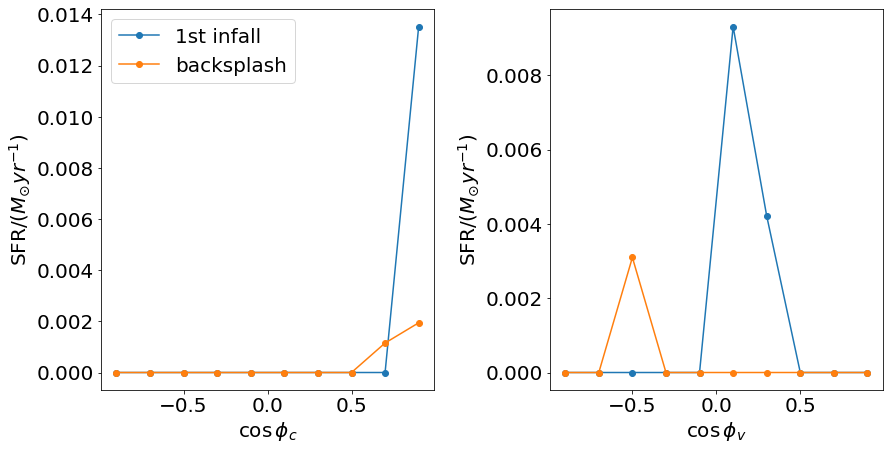

In [83]:
# cos V for both

pl.figure(figsize=(14, 7))
pl.subplots_adjust(wspace=0.35)
# sumC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, GASAbundances_V1[:,5]/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, GASAbundances_V2[:,5]/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# sumV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, GASAbundances_V1[:,5]/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, GASAbundances_V2[:,5]/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# data_1 = GASMasses_1
# data_2 = GASMasses_2
# weight_1 = 1./StarMass_1
# weight_2 = 1./StarMass_2

data_1 = temp_1
data_2 = temp_2
weight_1 = np.ones(temp_1.size)
weight_2 = np.ones(temp_2.size)

# data_1 = np.log10((GASAbundances_1[:,4]/FeMass)/(GASAbundances_1[:,6]/HMass)) - NfeNhe_sun
# # # data_1 = data_1 - temp_1
# # data_1 = temp_1
# i_1 = np.where((np.isinf(data_1)==False) & (np.isnan(data_1)==False))
# data_1 = data_1[i_1]
# CosRc_1 = CosRc_1[i_1]
# CosRv_1 = CosRv_1[i_1]
# weight_1 = np.ones(temp_1[i_1].size)

# data_2 = np.log10((GASAbundances_2[:,4]/FeMass)/(GASAbundances_2[:,6]/HMass)) - NfeNhe_sun
# # data_2 = data_2 - temp_2
# # data_2 = temp_2
# i_2 = np.where((np.isinf(data_2)==False) & (np.isnan(data_2)==False))
# data_2 = data_2[i_2]
# CosRc_2 = CosRc_2[i_2]
# CosRv_2 = CosRv_2[i_2]
# weight_2 = np.ones(temp_2[i_2].size)


# weight_1 = np.log10((GASAbundances_1[:,4]/FeMass)/(GASAbundances_1[:,6]/HMass)) - NfeNhe_sun
# weight_1 = (GASAbundances_1[:,4]/FeMass)/(GASAbundances_1[:,6]/HMass)
# weight_1 = temp_1
# i_1 = np.where((np.isinf(weight_1)==False) & (np.isnan(weight_1)==False))
# weight_1 = weight_1[i_1]
# miwe_1 = weight_1.min()
# weight_1 = weight_1 - miwe_1

# CosRc_1 = CosRc_1[i_1]
# CosRv_1 = CosRv_1[i_1]

# data_1 = temp2_1[i_1]

# weight_2 = np.log10((GASAbundances_2[:,4]/FeMass)/(GASAbundances_2[:,6]/HMass)) - NfeNhe_sun
# weight_2 = (GASAbundances_2[:,4]/FeMass)/(GASAbundances_2[:,6]/HMass)
# weight_2 = temp_2
# i_2 = np.where((np.isinf(weight_2)==False) & (np.isnan(weight_2)==False))

# weight_2 = weight_2[i_2]
# miwe_2 = weight_2.min()
# weight_2 = weight_2 - miwe_2 # one will weight 0, but, well, *shrughs*

# CosRc_2 = CosRc_2[i_2]
# CosRv_2 = CosRv_2[i_2]

# data_2 = temp2_2[i_2]

sumC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))

# WsumC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, weight_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, weight_2, statistic='sum', bins=10, range=(-1.,1.))
# WsumV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, weight_1, statistic='sum', bins=10, range=(-1.,1.))
# WsumV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, weight_2, statistic='sum', bins=10, range=(-1.,1.))

# sumC_1 = sumC_1/WsumC_1
# sumC_2 = sumC_2/WsumC_2
# sumV_1 = sumV_1/WsumV_1
# sumV_2 = sumV_2/WsumV_2

# sumC_1e = sumC_1[zipC_1-1]
# sumC_2e = sumC_2[zipC_2-1]
# sumV_1e = sumV_1[zipV_1-1]
# sumV_2e = sumV_2[zipV_2-1]

# stdC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, ((data_1-sumC_1e)*weight_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, ((data_2-sumC_2e)*weight_2)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, ((data_1-sumV_1e)*weight_1)**2., statistic='sum', bins=10, range=(-1.,1.))
# stdV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, ((data_2-sumV_2e)*weight_2)**2., statistic='sum', bins=10, range=(-1.,1.))

# numbC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, data_1, statistic='count', bins=10, range=(-1.,1.))
# numbC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, data_2, statistic='count', bins=10, range=(-1.,1.))
# numbV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, data_1, statistic='count', bins=10, range=(-1.,1.))
# numbV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, data_2, statistic='count', bins=10, range=(-1.,1.))

# errC_1 = np.sqrt(numbC_1/((numbC_1-1.)*WsumC_1**2.)*stdC_1)
# errC_2 = np.sqrt(numbC_2/((numbC_2-1.)*WsumC_2**2.)*stdC_2)
# errV_1 = np.sqrt(numbV_1/((numbV_1-1.)*WsumV_1**2.)*stdV_1)
# errV_2 = np.sqrt(numbV_2/((numbV_2-1.)*WsumV_2**2.)*stdV_2)


# sumC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, data_1*weight_1, statistic='median', bins=10, range=(-1.,1.))
# sumC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, data_2*weight_2, statistic='median', bins=10, range=(-1.,1.))
# sumV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, data_1*weight_1, statistic='median', bins=10, range=(-1.,1.))
# sumV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, data_2*weight_2, statistic='median', bins=10, range=(-1.,1.))

# errC_1 = errC_1 * np.sqrt(np.pi/2.)
# errC_2 = errC_2 * np.sqrt(np.pi/2.)
# errV_1 = errV_1 * np.sqrt(np.pi/2.)
# errV_2 = errV_2 * np.sqrt(np.pi/2.)


# bins should be the same
x_x = .5*(binsV_2[:-1]+binsV_2[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC_1, marker='o', label='1st infall')
pl.plot(x_x, sumC_2, marker='o', label='backsplash')

# pl.errorbar(x_x, sumC_1, yerr=errC_1, marker='o', label='1st infall')
# pl.errorbar(x_x, sumC_2, yerr=errC_2, marker='o', label='backsplash')

pl.legend(loc='best')

pl.xlabel('$\cos\,\phi_c$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('[Fe/H]')
# pl.ylabel('Temperature/K')
# pl.ylabel('Gas Mass/Stellar Mass')
pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

pl.subplot(1, 2, 2)

pl.plot(x_x, sumV_1, marker='o', label='1st infall')
pl.plot(x_x, sumV_2, marker='o', label='backsplash')

# pl.errorbar(x_x, sumV_1, yerr=errV_1, marker='o', label='1st infall')
# pl.errorbar(x_x, sumV_2, yerr=errV_2, marker='o', label='backsplash')

pl.xlabel('$\cos\,\phi_v$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('[Fe/H]')
# pl.ylabel('Temperature/K')
# pl.ylabel('Gas Mass/Stellar Mass')
pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

# pl.savefig('paperGraphs/phiAll_byDir.pdf')

In [84]:
# with h5py.File('SatelliteList_1stInfall_n500_KoK04.h5', 'w') as f:
#     f.create_dataset('SatelliteList', data=sat_1)
#     f.create_dataset('SatelliteCentral', data=cent_1)

In [85]:
sim['SnapNumber_128/Groups/'].keys()

<KeysViewHDF5 ['Contamination', 'GroupCM', 'GroupLen', 'GroupLenType', 'GroupMassType', 'GroupNsubs', 'GroupNumber', 'GroupSFR', 'Group_M_Crit200', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Mean200', 'Group_R_TopHat200', 'PartType0', 'PartType1', 'PartType4', 'PartType5', 'SnapNumber']>